In [18]:
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from pymongo import MongoClient
cl = MongoClient()
db = cl['flights']
col = db['ddr2_flights']
col_combi = db['combi_ddr2_adsb']

<h2>Visualization of DDR2 and ADS-B data sets</h2>
The following code will plot the parsed DDR2 and ADS-B flights which have already been merged based on callsign and timestamp. Within the DDR2 flights there are both m1 and m3 files for respectively the planned and actual route. The ADS-B data is more granular. Interesting to see is that there are differences as well between DDR2-m3 and ADS-B

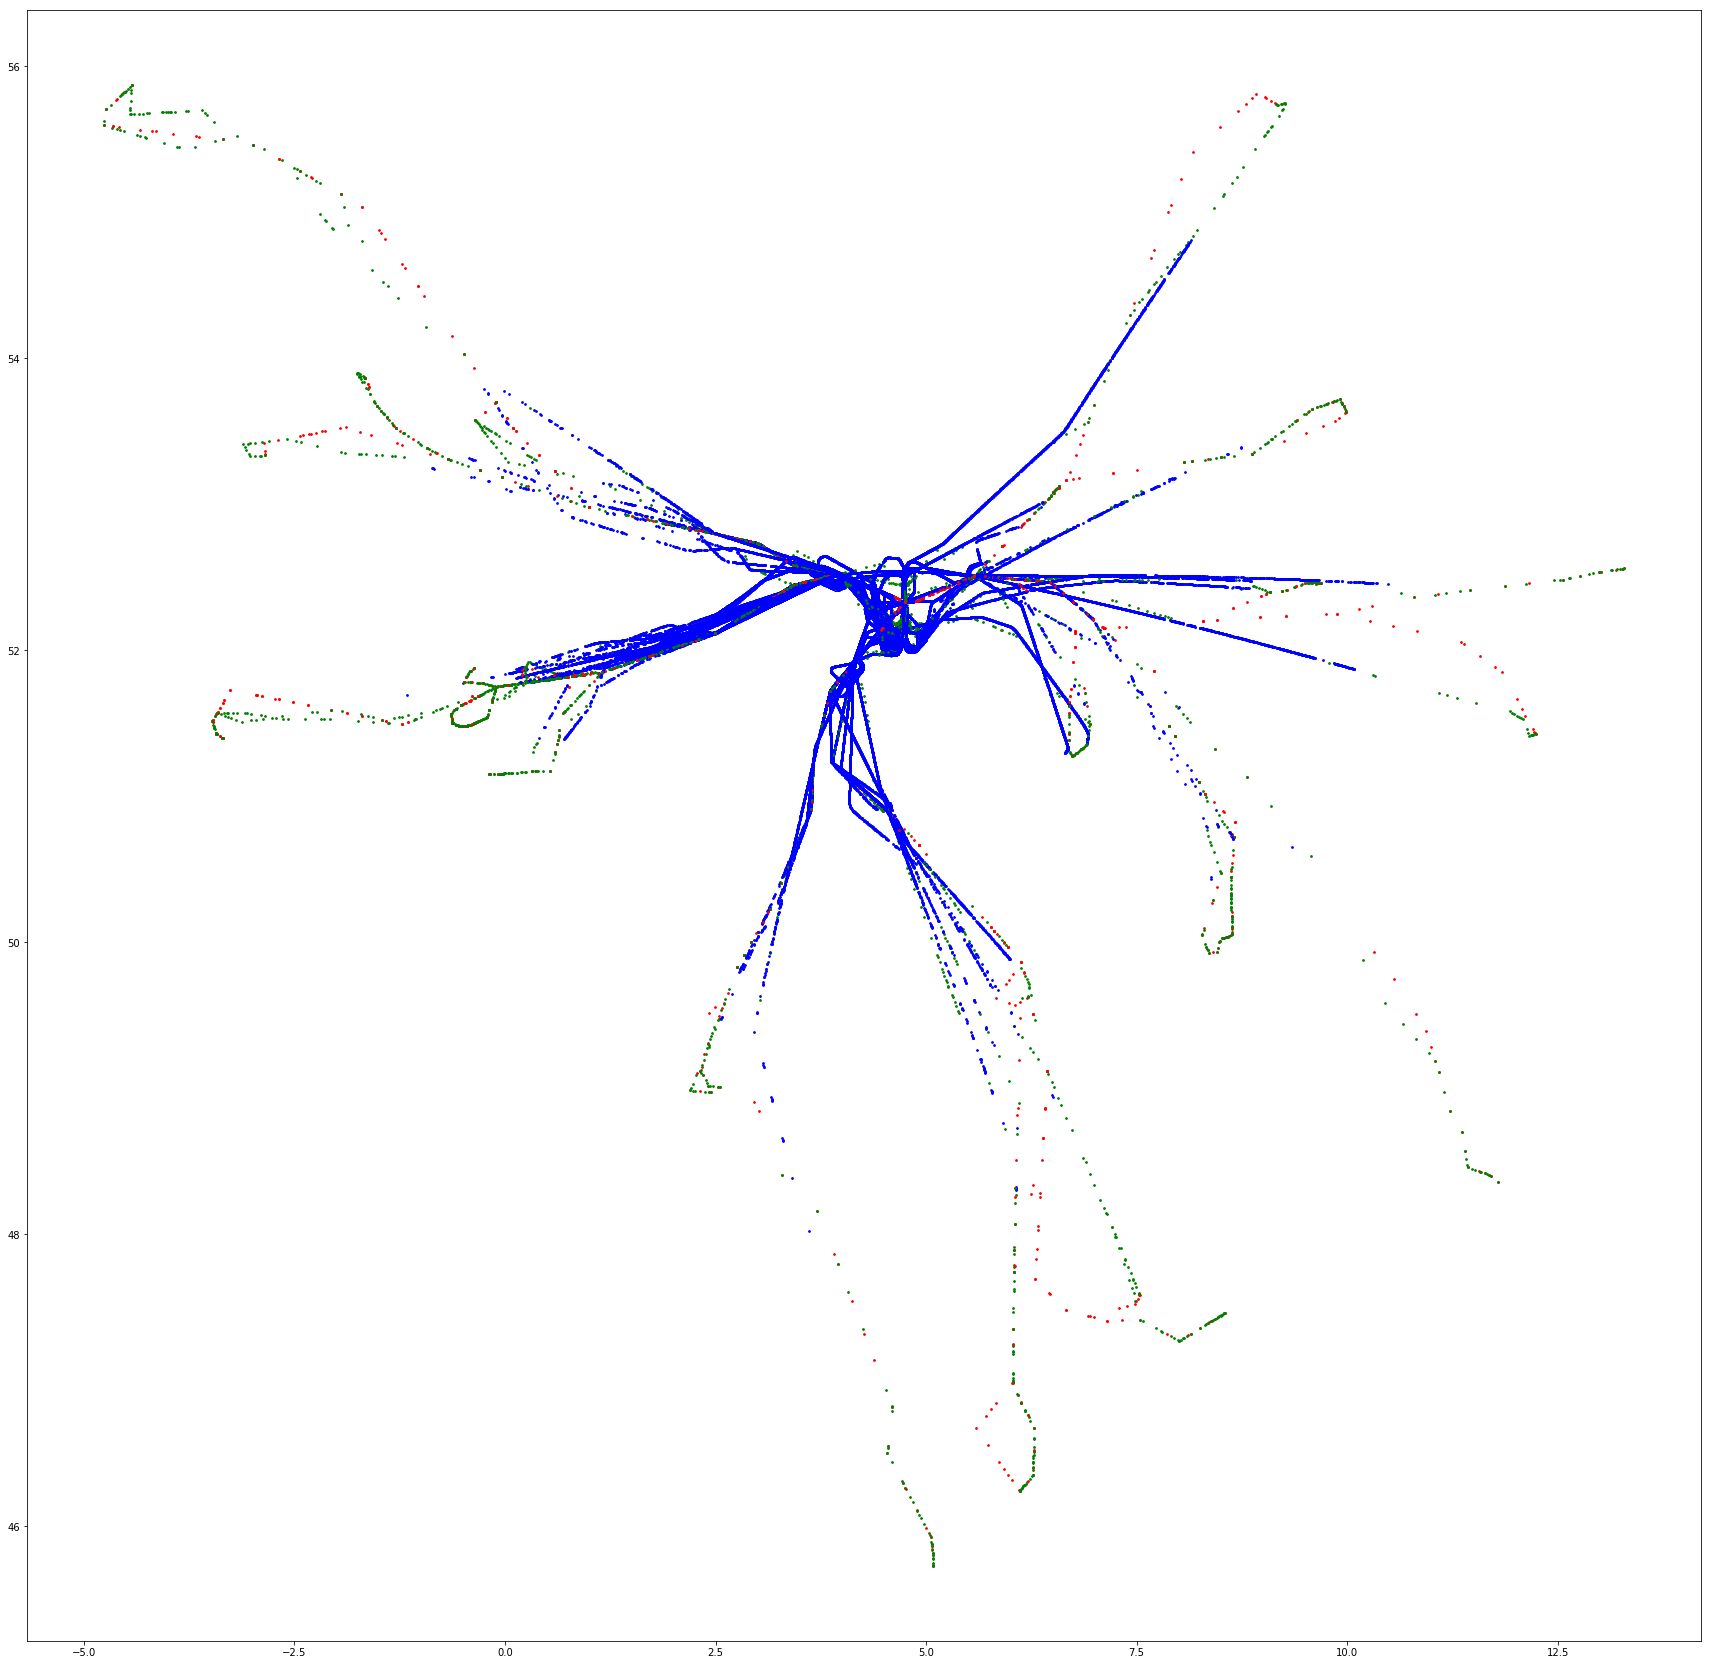

In [2]:
plt.figure(figsize=(30,30))
lat_bounds = [51, 53]
lon_bounds = [4, 5.5]

for x in col_combi.find({})[:50]:
    try:
        a = pd.DataFrame(x['adsb'])
        dm1 = pd.DataFrame(x['ddr2_m1'])
        dm3 = pd.DataFrame(x['ddr2_m3'])
        plt.scatter(list(dm1['lon_seg_b']),list(dm1['lat_seg_b']), c="r", s=3)
        plt.scatter(list(dm3['lon_seg_b']),list(dm3['lat_seg_b']), c="g", s=3)
        plt.scatter(list(a['lon']),list(a['lat']), c="b", s=3)
    except:
        continue

    
plt.show()

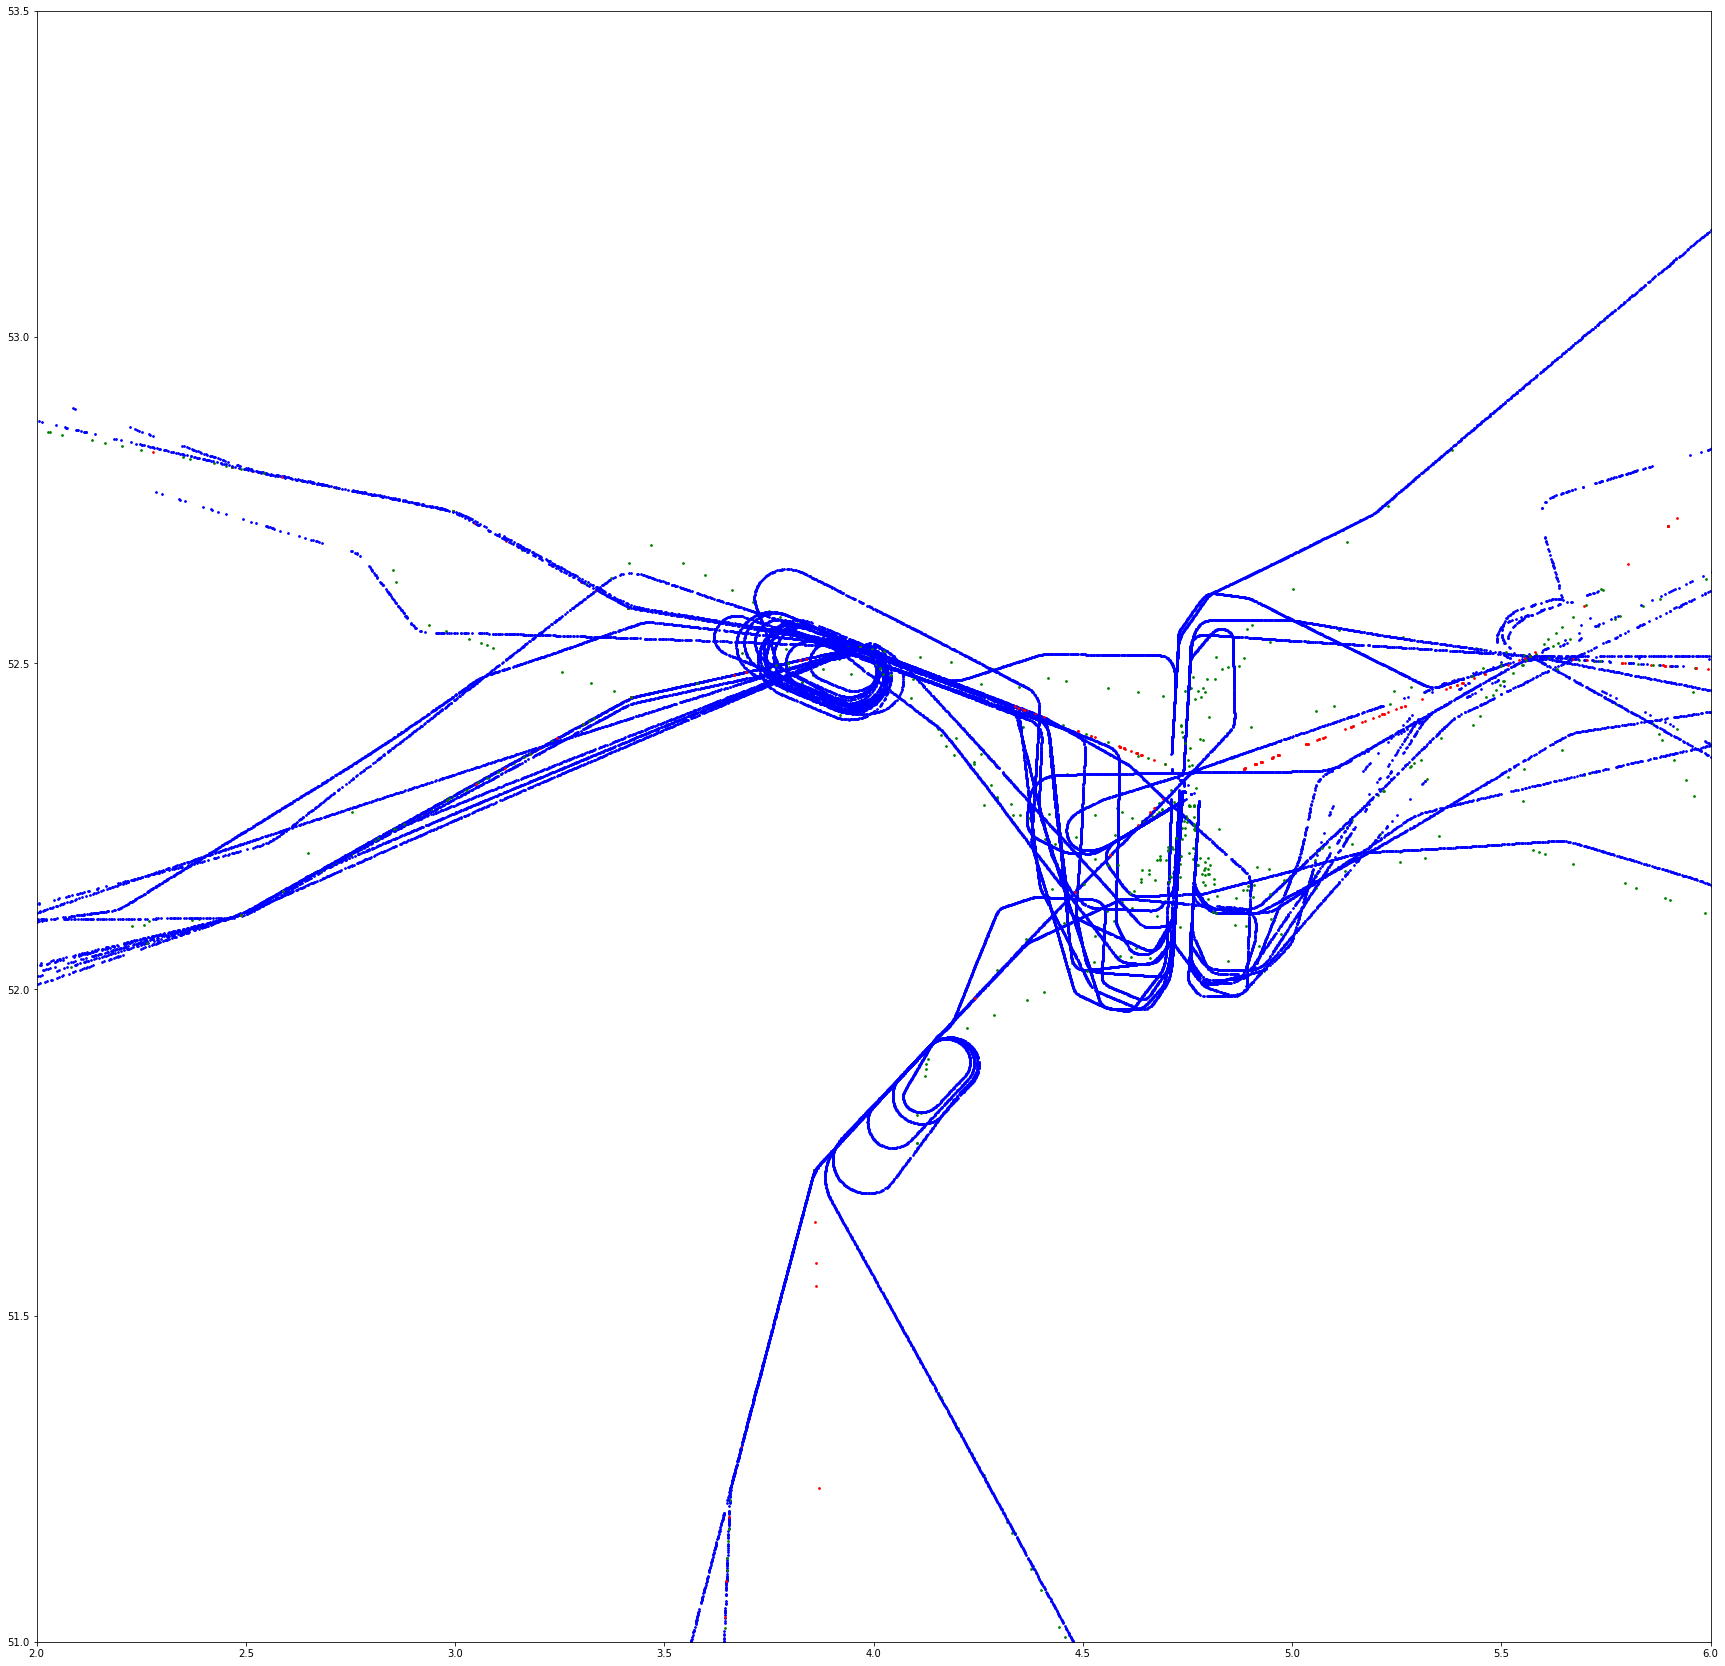

In [12]:
plt.figure(figsize=(30,30))
lat_bounds = [51, 53.5]
lon_bounds = [2, 6]

for x in col_combi.find({})[:30]:
    try:
        a = pd.DataFrame(x['adsb'])
        dm1 = pd.DataFrame(x['ddr2_m1'])
        dm3 = pd.DataFrame(x['ddr2_m3'])
        plt.scatter(list(dm1['lon_seg_b']),list(dm1['lat_seg_b']), c="r", s=3)
        plt.scatter(list(dm3['lon_seg_b']),list(dm3['lat_seg_b']), c="g", s=3)
        plt.scatter(list(a['lon']),list(a['lat']), c="b", s=3)
        plt.xlim(tuple(lon_bounds))
        plt.ylim(tuple(lat_bounds))
    except:
        continue

    
plt.show()

In [14]:
import math

def calc_coord_dst(c1, c2):
    R = 6371.1 * 1000 # Radius of the Earth in m

    lat1 = c1[0]
    lon1 = c1[1]
    lat2 = c2[0]
    lon2 = c2[1]

    [lon1, lat1, lon2, lat2] = [math.radians(l) for l in [lon1, lat1, lon2, lat2]]

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    d = R * c
    return d


def get_triangle_corner(d0, d1, d2):
    bb = (d0 ** 2 + d1 ** 2 - d2 ** 2) / (2 * d0 * d1)
    return math.degrees(math.acos(bb))


def evaluate_triangle(wp_1, wp_2, wp_ac):

    [d_12, d_ac1, d_ac2] = [calc_coord_dst(wp_1, wp_2), calc_coord_dst(wp_1, wp_ac), calc_coord_dst(wp_2, wp_ac)]

    alpha_1 = get_triangle_corner(d_12, d_ac1, d_ac2)
    alpha_2 = get_triangle_corner(d_12, d_ac2, d_ac1)
    alpha_ac = get_triangle_corner(d_ac2, d_ac1, d_12)

    return alpha_1, alpha_2, alpha_ac


def evaluate_waypoints(wp_ac, last_wp, curr_wp, next_wp):

    [wp_11, wp_12, wp_21, wp_22] = [last_wp, curr_wp, curr_wp, next_wp]

    a_11, a_12, a_1ac = evaluate_triangle(wp_11, wp_12, wp_ac)
    a_21, a_22, a_2ac = evaluate_triangle(wp_21, wp_22, wp_ac)

    
    if a_12 > a_21:
        return True
    else:
        return False


def find_closest_waypoint_index(wp, wp_list):

    dst = [calc_coord_dst(wp, wpi) for wpi in wp_list]
    ix = dst.index(min(dst))

    return ix

def get_triangle_height(d0, d1, d2):
    
    x = (d2**2 - d1**2 + d0**2)/(2*d0)
    h = math.sqrt(d2**2 - x**2)
    
    return h


def find_waypoint_index(wp, wp_list):

    wp_ac = wp
    hi_lst = []
    
    for i,w in enumerate(wp_list[:-1]):
        wp_0 = w
        wp_1 = wp_list[i+1]
        
        a_0, a_1, a_ac = evaluate_triangle(wp_0, wp_1, wp_ac)
        
        if (abs(a_0) < 90) & (abs(a_1) < 90):
            d0 = calc_coord_dst(wp_0,wp_1)
            d1 = calc_coord_dst(wp_1,wp_ac)
            d2 = calc_coord_dst(wp_0,wp_ac)
            
            hi = get_triangle_height(d0,d1,d2)
            hi_lst.append((i,hi))
        
    if hi_lst:
        iwp = min(hi_lst, key = lambda t: t[1])[0]
    else:
        iwp = find_closest_waypoint_index(wp, wp_list)
    
    return iwp


def add_waypoints_seq(flight_df, route_wps):

    # Reset index to start at 0
    # Ensure all lat and lon values exist in the used rows
    flight_df = flight_df[(flight_df['lat'].notnull() & flight_df['lon'].notnull())]
    flight_df = flight_df.reset_index(drop=True)
    route_wps = route_wps.reset_index(drop=True)

    last_wp_list = [0] * len(flight_df)
    curr_wp_list = [0] * len(flight_df)
    next_wp_list = [0] * len(flight_df)
    wp_ac_list = [0] * len(flight_df)

    for i, r in flight_df.iterrows():

        wp_ac = (r['lat'], r['lon'])

        if i == 0:
            #             last_wp = (r['lat'], r['lon'])
            last_wp_ix = find_closest_waypoint_index(wp_ac, route_wps)
            curr_wp_i = last_wp_ix + 1

        last_wp = route_wps[curr_wp_i - 1]
        curr_wp = route_wps[curr_wp_i]
        next_wp = route_wps[curr_wp_i + 1]

        last_wp_list[i] = last_wp
        curr_wp_list[i] = curr_wp
        next_wp_list[i] = next_wp
        wp_ac_list[i] = wp_ac

        switch = evaluate_waypoints(wp_ac, last_wp, curr_wp, next_wp)

        if switch:
            if curr_wp_i < (len(route_wps) -2):
                # last_wp = route_wps[curr_wp_i]
                curr_wp_i = curr_wp_i + 1
            else:
                flight_df['last_wp'] = last_wp_list
                flight_df['curr_wp'] = curr_wp_list
                flight_df['next_wp'] = next_wp_list
                flight_df['wp_ac'] = wp_ac_list

                return flight_df

    flight_df['last_wp'] = last_wp_list
    flight_df['curr_wp'] = curr_wp_list
    flight_df['next_wp'] = next_wp_list
    flight_df['wp_ac'] = wp_ac_list

    return flight_df

def add_waypoints_free(flight_df, route_wps):

    # Reset index to start at 0
    # Ensure all lat and lon values exist in the used rows
    flight_df = flight_df[(flight_df['lat'].notnull() & flight_df['lon'].notnull())]
    flight_df = flight_df.reset_index(drop=True)
    route_wps = route_wps.reset_index(drop=True)

    last_wp_list = [0] * len(flight_df)
    curr_wp_list = [0] * len(flight_df)
    next_wp_list = [0] * len(flight_df)
    wp_ac_list = [0] * len(flight_df)

    for i, r in flight_df.iterrows():

        wp_ac = (r['lat'], r['lon'])
        
            #             last_wp = (r['lat'], r['lon'])
#         curr_wp_i = find_closest_waypoint_index(wp_ac, route_wps)
#         curr_wp_i = last_wp_ix + 1
        
        curr_wp_i = find_waypoint_index(wp_ac, route_wps)
        
        if curr_wp_i == 0:
            curr_wp_i = 1

        if curr_wp_i < (len(route_wps) -2):
            
            last_wp = route_wps[curr_wp_i - 1]
            curr_wp = route_wps[curr_wp_i]
            next_wp = route_wps[curr_wp_i + 1]

            last_wp_list[i] = last_wp
            curr_wp_list[i] = curr_wp
            next_wp_list[i] = next_wp
            wp_ac_list[i] = wp_ac

        else:
            flight_df['last_wp'] = last_wp_list
            flight_df['curr_wp'] = curr_wp_list
            flight_df['next_wp'] = next_wp_list
            flight_df['wp_ac'] = wp_ac_list

            return flight_df

    flight_df['last_wp'] = last_wp_list
    flight_df['curr_wp'] = curr_wp_list
    flight_df['next_wp'] = next_wp_list
    flight_df['wp_ac'] = wp_ac_list

    return flight_df


def calc_bearing(c0, c1):
    
    if not all(isinstance(i, tuple) for i in [c0, c1]):
        return np.nan

    lat1 = c0[0]
    lon1 = c0[1]
    lat2 = c1[0]
    lon2 = c1[1]
    
    [lon1, lat1, lon2, lat2] = [math.radians(l) for l in [lon1, lat1, lon2, lat2]]

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(dlon)
    y = math.sin(dlon) * math.cos(lat2)
    bearing = math.atan2(y,x)

    return math.degrees(bearing)


def calc_compass_bearing(c0, c1):
    
    if not all(isinstance(i, tuple) for i in [c0, c1]):
        return np.nan

    lat1 = c0[0]
    lon1 = c0[1]
    lat2 = c1[0]
    lon2 = c1[1]
    
    [lon1, lat1, lon2, lat2] = [math.radians(l) for l in [lon1, lat1, lon2, lat2]]

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(dlon)
    y = math.sin(dlon) * math.cos(lat2)
    bearing = math.atan2(y,x)

    return (math.degrees(bearing) + 360) % 360


def find_coord_dst_hdg(coord1, hdg, dst):
    # https://stackoverflow.com/questions/7222382/get-lat-long-given-current-point-distance-and-bearing

    R = 6378.1  # Radius of the Earth in km
    hdg = math.radians(hdg)  # Bearing is converted to radians.
    d = dst / 1000  # Distance in km

    lat1 = math.radians(coord1[0])  # Current lat point converted to radians
    lon1 = math.radians(coord1[1])  # Current long point converted to radians

    lat2 = math.asin(math.sin(lat1) * math.cos(d / R) +
                     math.cos(lat1) * math.sin(d / R) * math.cos(hdg))
    
    x = math.sin(hdg) * math.sin(d / R) * math.cos(lat1)
    y = math.cos(d / R) - math.sin(lat1) * math.sin(lat2)

    lon2 = lon1 + math.atan2(y,x)

    lat2 = math.degrees(lat2)
    lon2 = math.degrees(lon2)

    return (lat2, lon2)


def calc_track_errors(wp_0, wp_1, wp_ac):
    if not all(isinstance(i, tuple) for i in [wp_0, wp_1, wp_ac]):
        return np.nan, np.nan, np.nan

    dst_ac = calc_coord_dst(wp_0, wp_ac)
    a_0, a_1, a_ac = evaluate_triangle(wp_0, wp_1, wp_ac)

    hdg_wp0_wp1 = calc_bearing(wp_0, wp_1)
    hdg_wp0_wpac = calc_bearing(wp_0, wp_ac)

    wp_proj = find_coord_dst_hdg(wp_0, hdg_wp0_wp1, dst_ac)
    dst_wp_proj = calc_coord_dst(wp_0, wp_proj)
    dst_proj_ac = calc_coord_dst(wp_ac, wp_proj)
    
    hdg_wp0_wpac = calc_bearing(wp_0, wp_ac)
    alpha_2 = math.radians(hdg_wp0_wpac - hdg_wp0_wp1)

    try:
        cte = math.sin(alpha_2) * dst_ac
        ate = math.sqrt(dst_ac ** 2 - cte ** 2) - dst_ac
        tte = dst_proj_ac
    except Exception as e:
        print(e)
        cte = np.nan
        tte = np.nan
        ate = np.nan

    if dst_ac < dst_wp_proj:
        ate = -1 * ate

    return cte, ate, tte


<h2>Visualization of CTE over look ahead time for planned route</h2>
The calculated CTE between the DDR2-m1 data and ADS-B data is plotted against the look-ahead time. 

math domain error


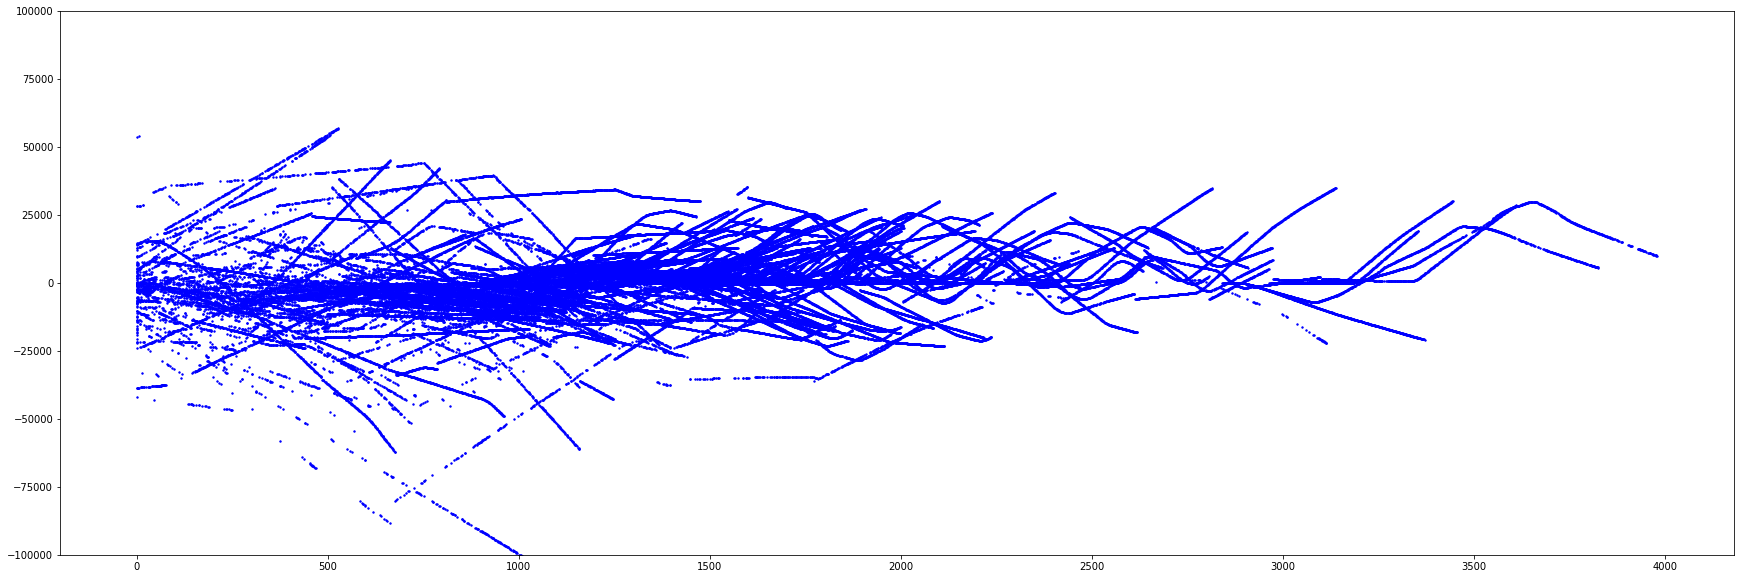

In [31]:
import matplotlib.pyplot as plt

proj_dct = {}
plt.figure(figsize=(30,10))
bin_cte = []
bin_dp_df = {}
la_time = 3000
bin_sec = 20

for x in col_combi.find({})[:100]:
    a = pd.DataFrame(x['adsb'])
    d = pd.DataFrame(x['ddr2_m1'])

    dc = d[['ep_seg_b','lat_seg_b', 'lon_seg_b']]
    ac = a[['ts','lat','lon']]

    dc['wps'] = list(zip(dc.lat_seg_b, dc.lon_seg_b))
    try:
        df = add_waypoints_free(ac, dc['wps'])
    except Exception as e:
        print(e)
        continue

    df[['curr_lat', 'curr_lon']] = df['curr_wp'].apply(pd.Series)
    df[['next_lat', 'next_lon']] = df['next_wp'].apply(pd.Series)
    df[['last_lat', 'last_lon']] = df['last_wp'].apply(pd.Series)
    
    cte_arr = []
    ate_arr = []
    tte_arr = []

    fl_dd = pd.DataFrame()

    for ii, r in df.iterrows():

        cte, ate, tte = calc_track_errors(r['last_wp'], r['curr_wp'], r['wp_ac'])
        cte_arr.append(cte)
        ate_arr.append(ate)
        tte_arr.append(tte)


    fl_dd['cte'] = cte_arr
    fl_dd['ate'] = ate_arr
    fl_dd['tte'] = tte_arr
    fl_dd['time_proj'] = df['ts'] - df['ts'].min()
    
    for b in range(int(la_time/bin_sec)):
        bmin = b*bin_sec
        bmax = (b+1)*bin_sec
        if str(bmax)+'_cte' not in list(bin_dp_df.keys()):
            bin_dp_df[str(bmax)+'_cte'] = []
            
        bin_dp_df[str(bmax)+'_cte'].extend(fl_dd['cte'][(fl_dd['time_proj'] >= bmin) & (fl_dd['time_proj'] <= bmax)])
    
    bin_cte.extend(cte_arr)
    
    plt.scatter(fl_dd['time_proj'],fl_dd['cte'],s=2, c='b')
    plt.ylim((-100000,100000))
    
plt.show()


The following boxplot shows the distribution of the CTE between the m1 data and ADS-B data in bins of 20 seconds for a look-ahead time up to 3000 seconds from the start of the flight. 

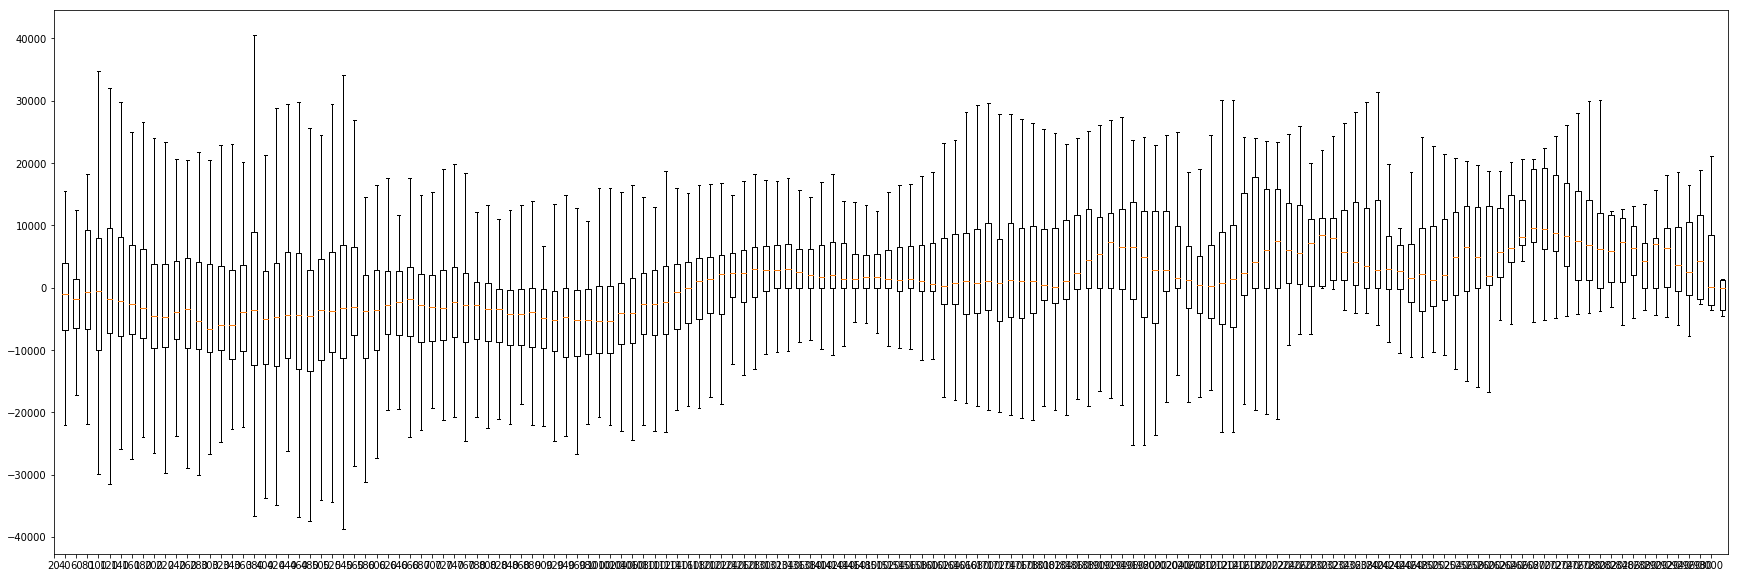

In [32]:
# create bin dataframe
box_data = []
bin_df = bin_dp_df

for k in bin_df.keys():
    if '_cte' in k:
        box_data.append((int(k.strip('_cte')), [i for i in bin_df[k] if not np.isnan(i)]))
    
box_data_sort = sorted(box_data, key=lambda tup: tup[0])
box_data_2 = [i[1] for i in box_data_sort]

x = range(len(box_data_2))
plt.figure(figsize=(30,10))
plt.boxplot(box_data_2, showfliers=False)
plt.xticks(x, [i[0] for i in box_data_sort])
plt.show()

math domain error


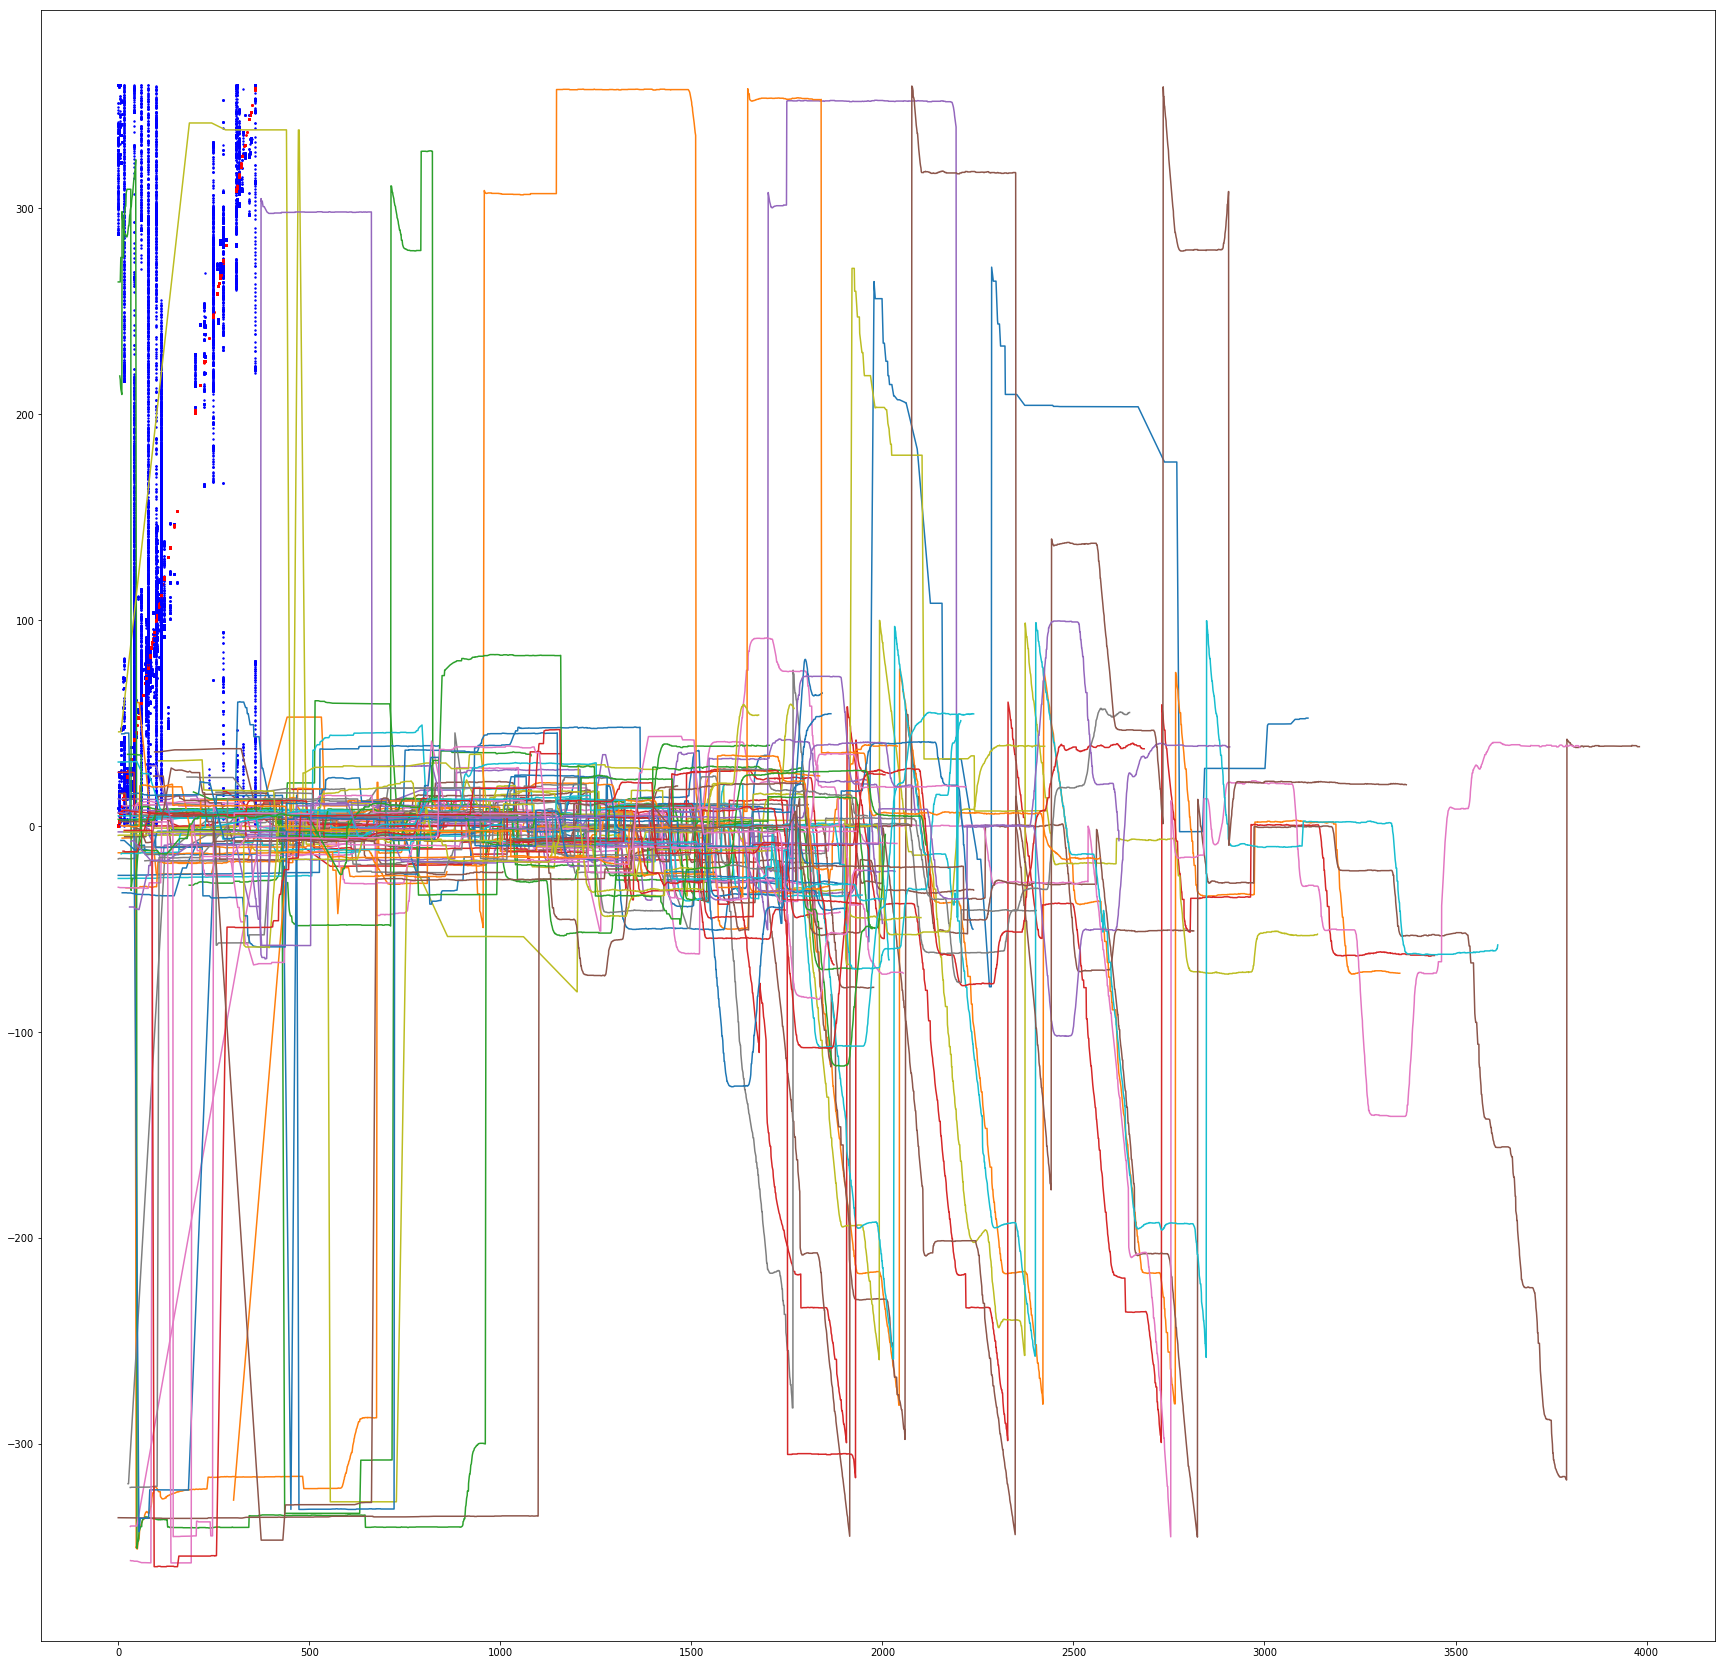

In [40]:
proj_dct = {}
plt.figure(figsize=(30,30))
bin_cte_hdg = []

for x in col_combi.find({})[:100]:
    a = pd.DataFrame(x['adsb'])
    d = pd.DataFrame(x['ddr2_m1'])

    dc = d[['ep_seg_b','lat_seg_b', 'lon_seg_b']]
    ac = a[['ts','lat','lon','hdg']]

    dc['wps'] = list(zip(dc.lat_seg_b, dc.lon_seg_b))
    try:
        df = add_waypoints_free(ac, dc['wps'])
    except Exception as e:
        print(e)
        continue

    df[['curr_lat', 'curr_lon']] = df['curr_wp'].apply(pd.Series)
    df[['next_lat', 'next_lon']] = df['next_wp'].apply(pd.Series)
    df[['last_lat', 'last_lon']] = df['last_wp'].apply(pd.Series)
    
    hdg_ac_arr = []
    hdg_route_arr = []
    hdg_diff_arr = []

    fl_dd = pd.DataFrame()

    for ii, r in df.iterrows():

        route_hdg = calc_compass_bearing(r['last_wp'], r['curr_wp'])
        hdg_ac_arr.append(r['hdg'])
        hdg_route_arr.append(route_hdg)
        hdg_diff_arr.append(route_hdg - r['hdg'])

    fl_dd['hdg_ac'] = hdg_ac_arr
    fl_dd['hdg_ac'] = fl_dd['hdg_ac'].fillna(method='ffill')
    fl_dd['hdg_route'] = hdg_route_arr
    fl_dd['time_proj'] = df['ts'] - df['ts'].min()
    
    plt.scatter(fl_dd['hdg_route'],fl_dd['hdg_ac'],s=2, c='b')
    plt.scatter(fl_dd['hdg_route'],fl_dd['hdg_route'],s=2, c='r')
    plt.plot(fl_dd['time_proj'], fl_dd['hdg_route']-fl_dd['hdg_ac'])
    
    bin_cte_hdg.extend(hdg_diff_arr)
    
plt.show()
    
#     plt.figure(figsize=(30,30))
#     plt.scatter(df['curr_lon'],df['curr_lat'],s=2, c='b')
#     plt.scatter(df['lon'],df['lat'],s=2, c='r')
#     plt.show()
    
#     plt.figure(figsize=(30,30))
#     plt.plot(fl_dd['hdg_route'],'-b')
#     plt.plot(fl_dd['hdg_ac'], '-r')
#     plt.show()
#     bin_cte.extend(cte_arr)

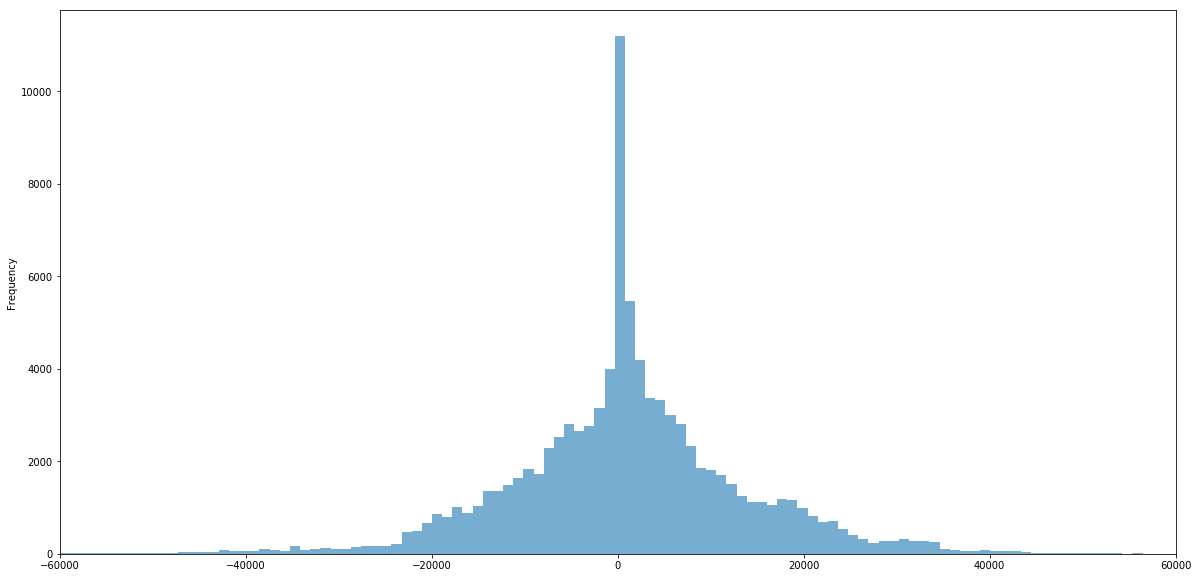

In [36]:
bin_cte = pd.Series(bin_cte)
bin_cte.plot.hist(bins=500,figsize=(20,10),xlim=(-60000,60000),alpha = 0.6)

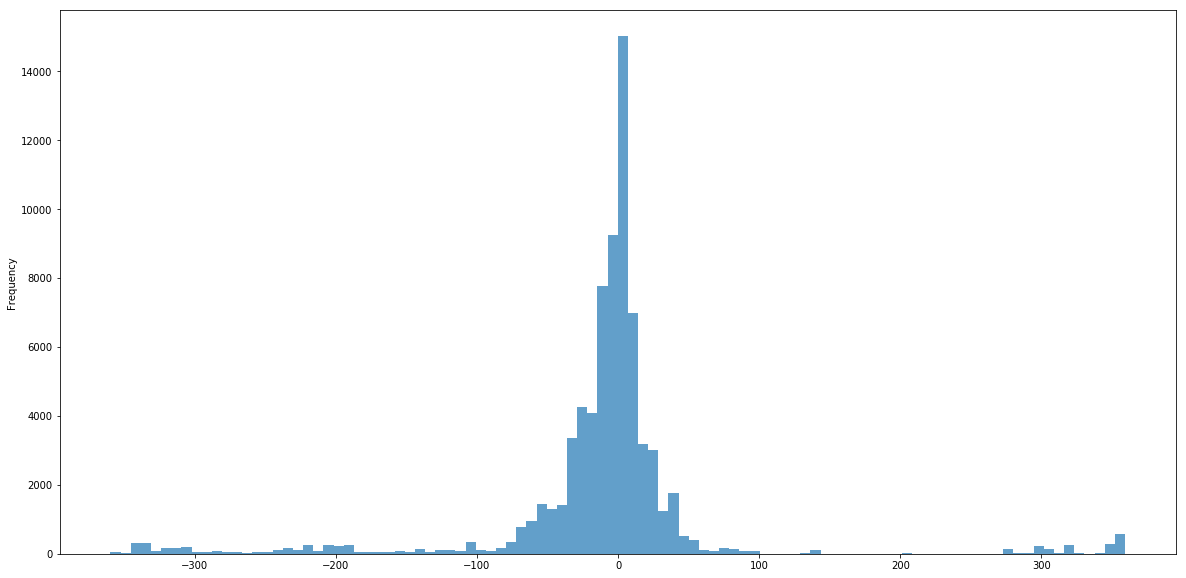

In [41]:
bin_cte_hdg = pd.Series(bin_cte_hdg)
bin_cte_hdg.plot.hist(bins=100,figsize=(20,10),alpha=0.7)

In [102]:
bin_cte.describe()

count    114594.000000
mean       -491.639384
std       13839.535325
min     -437363.927552
25%       -6796.822567
50%        -206.646696
75%        5421.334065
max      109395.468973
dtype: float64

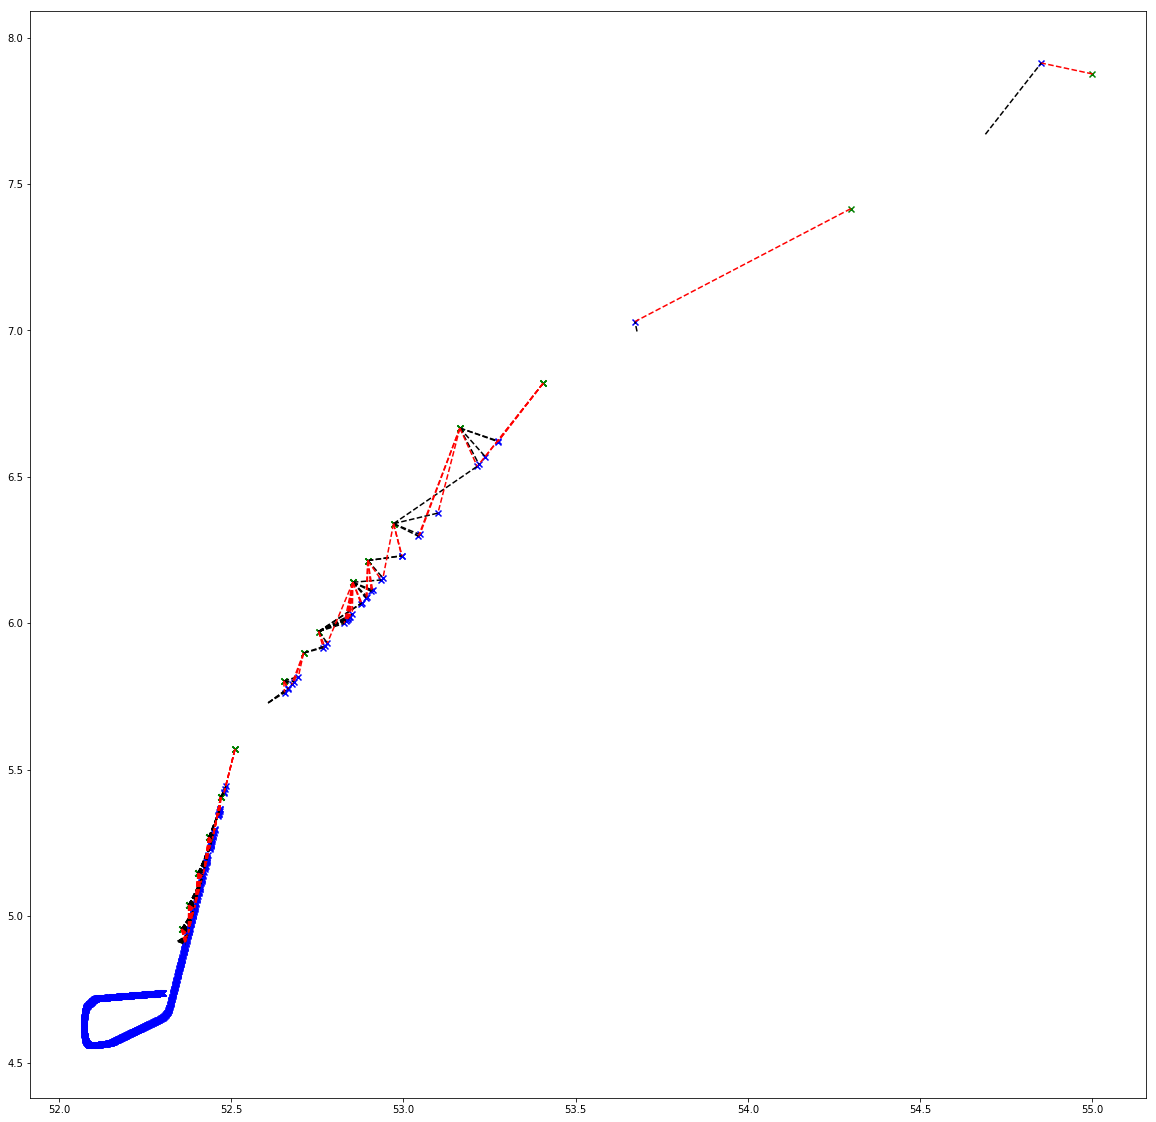

In [77]:
plt.figure(figsize=(20,20))
for i, r in df.iterrows(): 
    plt.plot([r['curr_lat'],r['lat']],[r['curr_lon'],r['lon']], 'r--')
    plt.plot([r['next_lat'],r['lat']],[r['next_lon'],r['lon']], 'k--')

for i, r in df.iterrows(): 
    plt.scatter(r['lat'],r['lon'],c='b',marker='x')
    plt.scatter(r['curr_lat'],r['curr_lon'],c='g',marker='x')
    
plt.show()